# Transfer Learning
using existing model (Inception) and retraining to identify cats vs dogs
<img src='K06_dataprep.png'>

# transfer_learn.py
 This program is an example of using Transfer Learning.  Transfer learning let apply the power of an existing powerful trained model to a dataset we are interested in.   In this example, we will use the Inveption-V3 model 
 This code was inspired by the post https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

 Cat and dog images can be found in the file train.zip found at  https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data.  
 create a folder named data.  Under that folder create the subfolders "train" and "validate"
* Copy 1000 "cat" files to the data/train/cat folder, 1000 "dog" files to the data/train/dog folder.
* Copy 400 different "cat" files to the data/validate/cat folder, 400 different "dog" files to the data/validate/dog folder.

In [5]:
#setup
import os
import matplotlib.pyplot as plt

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Suppress warning and informational messages
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Get count of number of files in this folder and all subfolders
#used to count training and test examples
def get_num_files(path):
  if not os.path.exists(path):
    return 0
  return sum([len(files) for r, d, files in os.walk(path)])

# Get count of number of subfolders directly below the folder in path
# count the number of classes
# to add a new class just add a folder of images e.g. 'horses'
def get_num_subfolders(path):
  if not os.path.exists(path):
    return 0
  return sum([len(d) for r, d, files in os.walk(path)])

#   Define image generators that will variations of image with the image r/otated slightly, shifted up, down, left, or right, 
#     sheared, zoomed in, or flipped horizontally on the vertical axis (ie. person looking to the left ends up looking to the right)
# done to augment the # images the model can be trained with
def create_img_generator():
  return  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )

In [10]:
train_dir = './data/train'
validate_dir = './data/validate'

num_train_samples = get_num_files(train_dir) 
num_classes = get_num_subfolders(train_dir)
num_validate_samples = get_num_files(validate_dir)
num_classes, num_train_samples, num_validate_samples

(2, 0, 0)

In [11]:
assert(num_classes == 2)
assert(num_train_samples == 1000)
assert(num_validate_samples == 400)

AssertionError: 

In [12]:
# Main Code
Image_width, Image_height = 299, 299 
Training_Epochs = 2
Batch_Size = 32
Number_FC_Neurons = 1024

num_epoch = Training_Epochs
batch_size = Batch_Size

In [13]:
# Define data pre-processing 
#   Define image generators for training and testing 
train_image_gen = create_img_generator()
test_image_gen = create_img_generator()

#   Connect the image generator to a folder contains the source images the image generator alters.  
#   Training image generator
# pull images from training folder and create batches of transformed images
train_generator = train_image_gen.flow_from_directory(
  train_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed = 42    #set seed for reproducability
)

#   Validation image generator
validation_generator = test_image_gen.flow_from_directory(
  validate_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed=42       #set seed for reproducability
)

Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


Inception v3 base model without last FC loaded
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
________________________________________

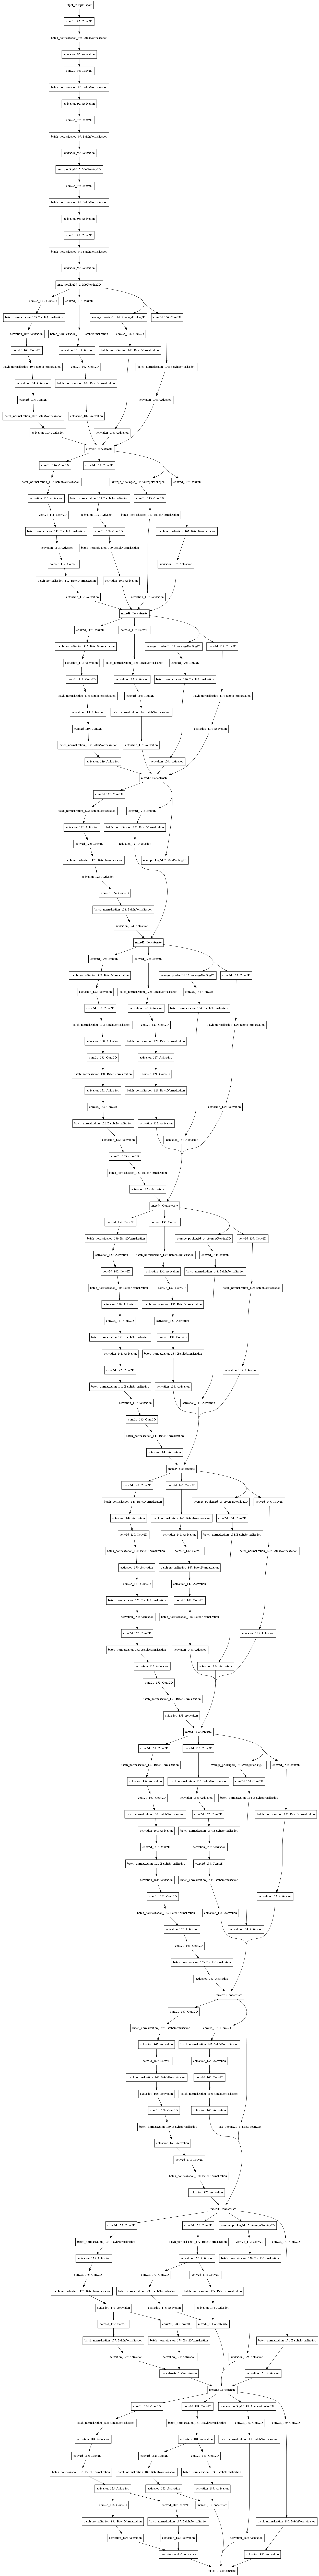

In [17]:
# Load the Inception V3 model and load it with it's pre-trained weights.  But exclude the final 
#    Fully Connected layer
#include_top=False excludes final FC layer
InceptionV3_base_model = InceptionV3(weights='imagenet', 
                                     include_top=False) 

print('Inception v3 base model without last FC loaded')
print(InceptionV3_base_model.summary())     # display the Inception V3 model hierarchy
from keras.utils import plot_model
plot_model(InceptionV3_base_model)

In [19]:
# Define the layers in the new classification prediction 
x = InceptionV3_base_model.output
x = GlobalAveragePooling2D()(x) #connect network to custom new layer
x = Dense(Number_FC_Neurons, activation='relu')(x)        # new FC layer, random init
predictions = Dense(num_classes, activation='softmax')(x)  # new softmax layer

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

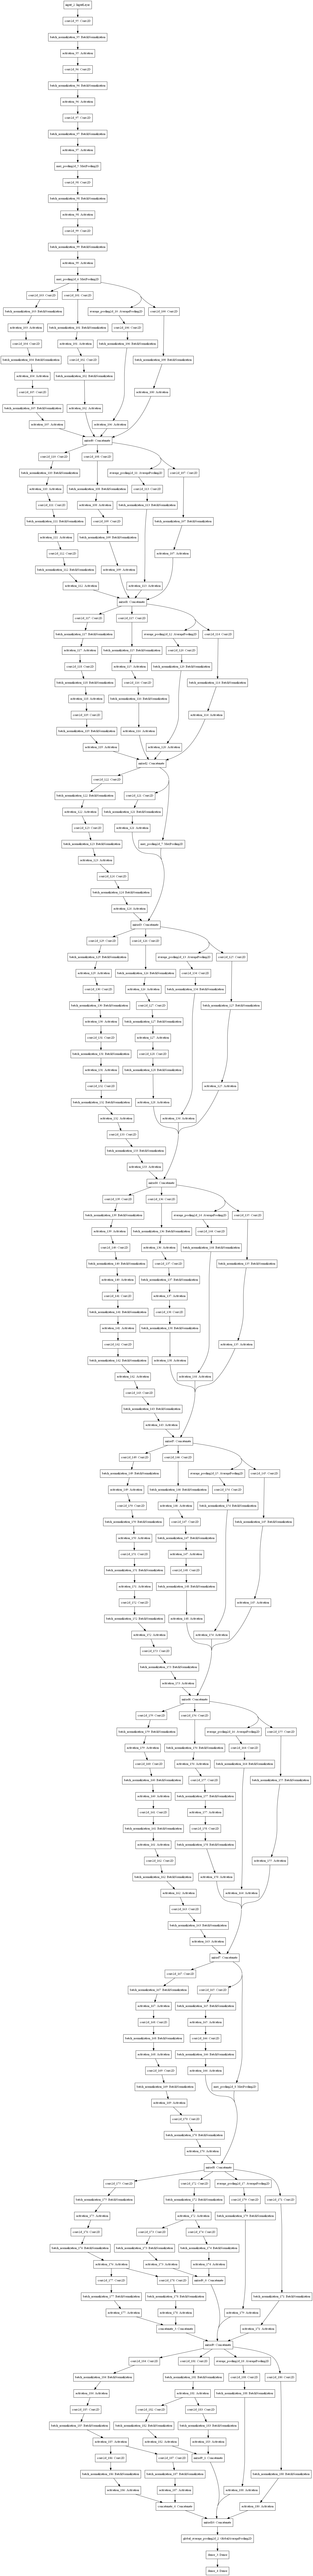

In [21]:
# Define trainable model which links input from the Inception V3 base model to the new classification prediction layers
model = Model(inputs=InceptionV3_base_model.input, outputs=predictions)

# print model structure diagram
print (model.summary()) # 23 million parameters
#only 2 million 
plot_model(model, to_file='K06_Inception_customized.png')

In [ ]:
# Option 1: Basic Transfer Learning
print ('\nPerforming Transfer Learning')
  #   Freeze all layers in the Inception V3 base model 
# only weights for unfrozen neurons will be trained 
for layer in InceptionV3_base_model.layers:
  layer.trainable = False
#   Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
# Fit the transfer learning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from 
# the training or validation folders and alter them slightly
history_transfer_learning = model.fit_generator(
  train_generator,
  epochs=num_epoch,
  steps_per_epoch = num_train_samples // batch_size,
  validation_data=validation_generator,
  validation_steps = num_validate_samples // batch_size,
  class_weight='auto')

In [ ]:
# Save transfer learning model
model.save('inceptionv3-transfer-learning.model')

In [ ]:
# Option 2: Transfer Learning with Fine-tuning - 
# retrain the end few layers (called the top layers) of the inception model
print('\nFine tuning existing model')
#   Freeze 
Layers_To_Freeze = 172
for layer in model.layers[:Layers_To_Freeze]:
  layer.trainable = False
for layer in model.layers[Layers_To_Freeze:]:
  layer.trainable = True
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the Fine-tuning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from the training or validation
# folders, alter then slightly, and pass the images back
history_fine_tune = model.fit_generator(
  train_generator,
  steps_per_epoch = num_train_samples // batch_size,
  epochs=num_epoch,
  validation_data=validation_generator,
  validation_steps = num_validate_samples // batch_size,
    class_weight='auto')

In [ ]:
# Save fine tuned model
model.save('inceptionv3-fine-tune.model')
